# Librerias

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly as py
import warnings
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import Birch
import joblib
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import json
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

# Carga de Datos
Cargamos el conjunto de datos desde un archivo Excel, utilizando `pandas` para leer el archivo y almacenar los datos en un DataFrame. 

In [ ]:
file_path = '../data/base_prueba_tecnica.xlsx'
df = pd.read_excel(file_path)
df.head()

,ID,Edad,Genero,Ingresos Anuales,Gasto Mensual,Puntuación de Crédito,Región,Comportamiento en linea,Compras en el ultimo año
0,1,21,Masculino,222011,2297,335,Sur,8,81
1,2,26,Masculino,239229,3420,329,Oeste,10,27
2,3,38,Masculino,716278,36965,711,Oeste,9,82
3,4,64,Femenino,697325,9846,855,Sur,2,6
4,5,52,Femenino,1032569,6607,989,Sur,3,2


# Preprocesamiento de Datos
Seleccionamos las columnas numéricas para el escalado y aplicamos `MinMaxScaler` para normalizar los datos al rango [0, 1]. Después, utilizamos Análisis de Componentes Principales (PCA) para reducir la dimensionalidad del conjunto de datos a tres componentes principales, lo cual facilitará la visualización y el análisis de clustering.


In [ ]:
numeric_columns = ['Edad', 'Ingresos Anuales', 'Gasto Mensual', 'Puntuación de Crédito', 'Comportamiento en linea', 'Compras en el ultimo año']
numeric_columns_no_id = [col for col in numeric_columns if col != 'ID']

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(df_scaled[numeric_columns])

# Entrenamiento del Modelo BIRCH
Entrenamos el modelo BIRCH, un algoritmo de clustering jerárquico, utilizando los datos con dimensiones reducidas. Configuramos el número de clusters a 3 y ajustamos el modelo. Guardamos el escalador, PCA y el modelo BIRCH para su uso futuro, asegurando la reproducibilidad del análisis.


In [ ]:
# Entrenar el modelo BIRCH
birch_model = Birch(n_clusters=3)  
birch_model.fit(X_reduced)

# Guardar el modelo BIRCH
joblib.dump(scaler, '../back/scaler.pkl')
joblib.dump(pca, '../back/pca.pkl')
joblib.dump(birch_model, '../back/birch_model.pkl')


['back/birch_model.pkl']

# Visualización de Resultados de Clustering
Cargamos el modelo BIRCH, el escalador y PCA previamente guardados y aplicamos el modelo a los datos reducidos para obtener las etiquetas de clustering. Utilizamos `seaborn` para crear gráficos de caja por cada característica numérica, agrupados por las etiquetas de clustering asignadas por BIRCH. Esto nos permite visualizar la distribución de los valores dentro de cada cluster y comparar entre los diferentes clusters.


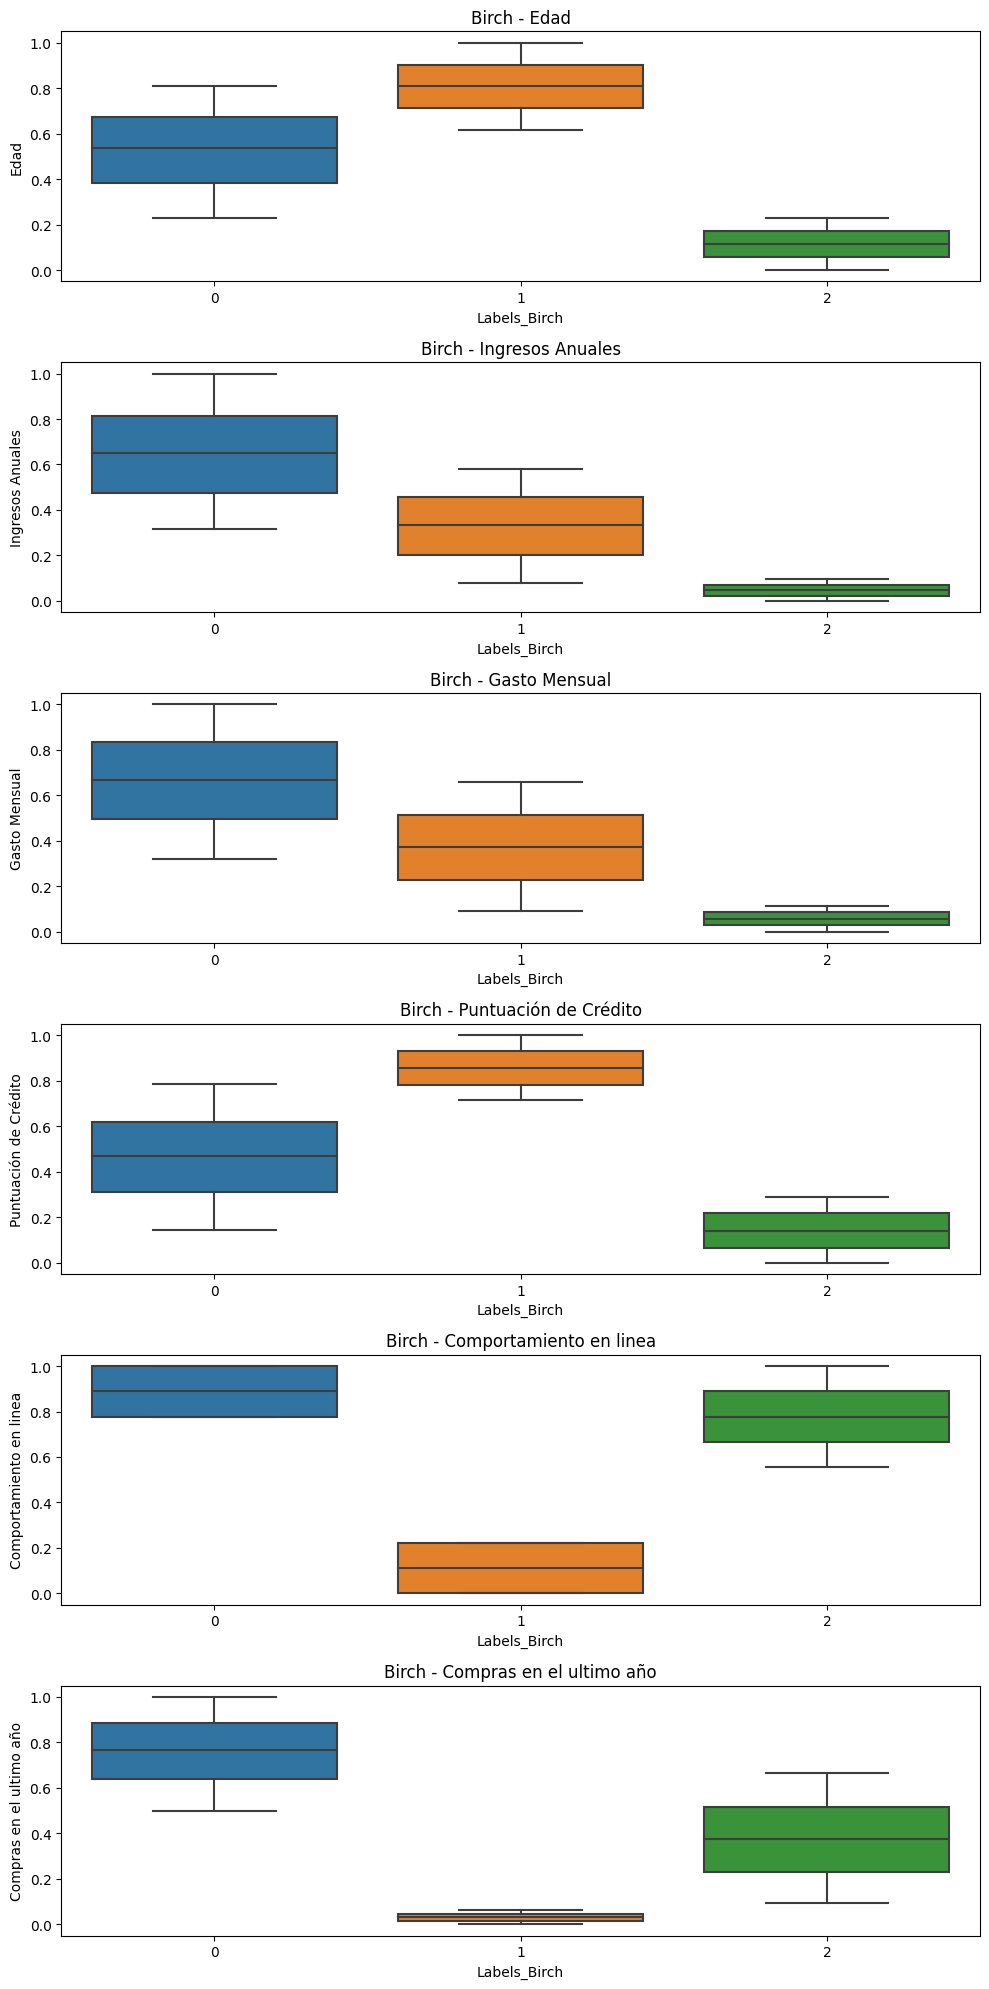

In [ ]:


le = LabelEncoder()
import joblib

# Cargar el modelo BIRCH, el escalador y PCA guardados
model = joblib.load('../back/birch_model.pkl')
scaler = joblib.load('../back/scaler.pkl')
pca = joblib.load('../back/pca.pkl')




model.fit(X_reduced)
labels = model.predict(X_reduced)
labels = le.fit_transform(labels)
    
df_scaled[f'Labels_Birch'] = labels

fig = plt.figure(figsize=(10, 20))  
for i, col in enumerate(numeric_columns_no_id, 1):
    ax = fig.add_subplot(len(numeric_columns_no_id), 1, i)  
    sns.boxplot(x='Labels_Birch', y=col, data=df_scaled, ax=ax)
    ax.set_title(f'Birch - {col}')

plt.tight_layout()
plt.show()


# Evaluación de la Calidad de los Clusters

Para evaluar la calidad de los clusters generados por el modelo BIRCH, utilizamos dos métricas relevantes: el Coeficiente de Silueta y el Índice Calinski-Harabasz.

- **Coeficiente de Silueta:** Esta métrica varía entre -1 y 1. Un valor alto indica que los objetos están bien emparejados con sus propios clusters y mal emparejados con los vecinos, lo que sugiere una buena separación y cohesión de los clusters.

- **Índice Calinski-Harabasz:** Calcula el cociente de la suma de la dispersión entre clusters y la dispersión dentro del cluster para todos los clusters. Un valor más alto de este índice indica que los clusters están mejor definidos, es decir, son más densos y están bien separados entre sí.

Estas métricas nos proporcionan una comprensión cuantitativa de cuán bien se han formado los clusters, ayudando a validar la efectividad del modelo BIRCH en nuestro conjunto de datos.


In [ ]:
silhouette_avg = silhouette_score(X_reduced, labels)
print(f"Coeficiente de Silueta: {silhouette_avg}")


calinski_harabasz_avg = calinski_harabasz_score(X_reduced, labels)
print(f"Índice Calinski-Harabasz: {calinski_harabasz_avg}")

Coeficiente de Silueta: 0.7399084313981444
Índice Calinski-Harabasz: 13381.718291994197


# Exportación de Resultados de Clustering
Exportamos los resultados del clustering, incluyendo las coordenadas reducidas de cada punto y su asignación de grupo, a un archivo JSON. 


In [ ]:
puntos = [{'x': float(x), 'y': float(y), 'z': float(z), 'grupo': int(grupo)} for (x, y, z), grupo in zip(X_reduced, df_scaled['Labels_Birch'])]

# Guardar los puntos y la información del grupo en un archivo JSON
with open('puntos_clasificados.json', 'w') as f:
    json.dump(puntos, f)

# Revertir Escalado de Datos
Para interpretar mejor los resultados del clustering en el contexto original de los datos, revertimos el escalado de las características numéricas. 

In [ ]:
df_numeric_descaled = pd.DataFrame(scaler.inverse_transform(df_scaled[numeric_columns]), columns=numeric_columns, index=df_scaled.index)

# Añadir la asignación de grupos al DataFrame desescalado
df_numeric_descaled['Cluster_Group'] = labels
df_numeric_descaled.head()

,Edad,Ingresos Anuales,Gasto Mensual,Puntuación de Crédito,Comportamiento en linea,Compras en el ultimo año,Cluster_Group
0,21.0,222011.0,2297.0,335.0,8.0,81.0,2
1,26.0,239229.0,3420.0,329.0,10.0,27.0,2
2,38.0,716278.0,36965.0,711.0,9.0,82.0,0
3,64.0,697325.0,9846.0,855.0,2.0,6.0,1
4,52.0,1032569.0,6607.0,989.0,3.0,2.0,1


# Predicción para Nuevos Registros
Demostramos cómo cargar el modelo BIRCH, el escalador y PCA guardados para clasificar nuevos registros. 

In [ ]:
representative_records_per_group = {}

for group in df_numeric_descaled['Cluster_Group'].unique():
    representative_records = df_numeric_descaled[df_numeric_descaled['Cluster_Group'] == group].head(3)
    representative_records_per_group[f"Grupo_{group}"] = [
        {
            "Edad": row['Edad'],
            "IngresosAnuales": row['Ingresos Anuales'],
            "GastoMensual": row['Gasto Mensual'],
            "PuntuacionDeCredito": row['Puntuación de Crédito'],
            "ComportamientoEnLinea": row['Comportamiento en linea'],
            "ComprasEnElUltimoAno": row['Compras en el ultimo año']
        }
        for _, row in representative_records.iterrows()
    ]

representative_records_per_group
representative_records_json = json.dumps(representative_records_per_group, indent=2)
print(representative_records_json)


{
  "Grupo_2": [
    {
      "Edad": 21.0,
      "IngresosAnuales": 222010.99999999997,
      "GastoMensual": 2297.0,
      "PuntuacionDeCredito": 335.0,
      "ComportamientoEnLinea": 8.0,
      "ComprasEnElUltimoAno": 81.0
    },
    {
      "Edad": 26.0,
      "IngresosAnuales": 239229.0,
      "GastoMensual": 3420.0,
      "PuntuacionDeCredito": 329.0,
      "ComportamientoEnLinea": 10.000000000000002,
      "ComprasEnElUltimoAno": 27.0
    },
    {
      "Edad": 25.0,
      "IngresosAnuales": 219830.0,
      "GastoMensual": 2340.0,
      "PuntuacionDeCredito": 483.0,
      "ComportamientoEnLinea": 9.0,
      "ComprasEnElUltimoAno": 43.0
    }
  ],
  "Grupo_0": [
    {
      "Edad": 38.0,
      "IngresosAnuales": 716278.0,
      "GastoMensual": 36965.0,
      "PuntuacionDeCredito": 710.9999999999999,
      "ComportamientoEnLinea": 9.0,
      "ComprasEnElUltimoAno": 82.0
    },
    {
      "Edad": 54.0,
      "IngresosAnuales": 1507977.0,
      "GastoMensual": 23613.999999999996,
  

In [ ]:
# Cargar el modelo BIRCH, el escalador y PCA guardados
birch_model_loaded = joblib.load('../back/birch_model.pkl')
scaler = joblib.load('../back/scaler.pkl')
pca = joblib.load('../back/pca.pkl')

# Diccionario de entrada
input_record = {
      "Edad": 68.0,
      "IngresosAnuales": 622926.0,
      "GastoMensual": 27275.0,
      "PuntuacionDeCredito": 964.0,
      "ComportamientoEnLinea": 3.0,
      "ComprasEnElUltimoAno": 7.0
    }

new_record = [[input_record["Edad"], input_record["IngresosAnuales"], input_record["GastoMensual"],
               input_record["PuntuacionDeCredito"], input_record["ComportamientoEnLinea"],
               input_record["ComprasEnElUltimoAno"]]]

# Escalar y reducir dims
new_record_scaled = scaler.transform(new_record)
new_record_reduced = pca.transform(new_record_scaled)

# Predecir el grupo para el nuevo registro
group = birch_model_loaded.predict(new_record_reduced)
print("El nuevo registro pertenece al grupo:", group[0])

El nuevo registro pertenece al grupo: 1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c3340da-be44-447c-b509-9b133ff28053' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>